# Transient CSEM for a homogeneous fullspace

Example how to use emg3d to model time-domain data, using FFTLog and DLF.

The example is based on the first example (Figures 3-4) of Mulder et al., 2008, Geophysics: "Time-domain modeling of electromagnetic diffusion with a frequency-domain code". These results are shown at the end of the notebook.

The published example took roughly **3.75 hours**, whereas here we need less than **2 minutes**. There are two main reasons for the speed gain:

1. gridding and
2. frequency selection.

Note re first point, gridding: We implemented here an adaptive gridding with various number of cells. Our calculation uses meshes between 36,864 (64x24x24) and 102,400 (64x40x40) cells, whereas Mulder et al., 2008, used 2,097,152 (128x128x128) for all frequencies.

Note re second point, frequency selection: We only used 14 frequencies from 0.05-20 Hz, whereas Mulder et al., 2008, used 26 frequencies from 0.01-100 Hz. Have a look at the repo https://github.com/empymod/frequency-selection .

**Requires**
- **emg3d >= 0.9.0**
- `empymod`, `discretize`


#### References

> Mulder, W. A., M. Wirianto, and E. Slob, 2008, Time-domain modeling of electromagnetic diffusion with a frequency-domain code: Geophysics, 73, F1-F8; DOI: [10.1190/1.2799093](https://doi.org/10.1190/1.2799093).

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt

# Name is used to store the data for each frequency.
name = 'Fullspace'

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')

## Model and Survey

### Model
- Homogeneous fullspace of 1 Ohm.m.

### Survey
- Source at origin.
- Receiver at an inline-offset of 900 m.
- Both source and receiver are x-directed electric dipoles.

In [3]:
src = [0, 0, 0]
rec = [900, 0, 0]
res = 1
depth = []

## Fourier Transforms parameters

We only calculate frequencies $0.05 < f < 21$ Hz, which yields enough precision for our purpose.

This means, instead of 30 frequencies from 0.0002 - 126.4 Hz, we only need 14 frequencies from 0.05 - 20.0 Hz.

In [4]:
# Define desired times.
time = np.logspace(-2, 1, 201)

# Initiate a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=time,
    fmin=0.05,
    fmax=21,
    ft='fftlog',  # Fourier transform to use
    ftarg={'pts_per_dec': 5, 'add_dec': [-2, 1], 'q': 0},
)

# Dense frequencies for comparison reasons
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()), np.log10(Fourier.freq_req.max()), 301)

   time        [s] :  0.01 - 10 : 201  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  0.000200364 - 126.421 : 30  [min-max; #]
   Calc. freq [Hz] :  0.0503292 - 20.0364 : 14  [min-max; #]


## Frequency-domain calculation

In [5]:
# To store the info of each frequency.
values = {}

In [6]:
gridinput = {
    'min_width': [20., 40.],  # Restrict the cell width within the survey domain.
    'return_info': True,      # To get back some information for later.
    'pps': 12,                # Many points, to have a small min cell width.
    'alpha': [1, 1.3, 0.01],  # Lower the alpha will improve the result, but slow down calculation.
}

# Start the timer.
runtime = emg3d.utils.Time()

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"\n{15*'='} {fi+1:2}/{Fourier.freq_calc.size} {15*'='} {frq:10.6f} Hz {40*'='}\n")
    
    # Key is used to store the data etc.
    key = int(frq*1e6)
          
    # Initiate log for this frequency.
    values[key] = {}
    values[key]['freq'] = frq

    # Get cell widths and origin in each direction
    # - source location is grid center.
    # - We use 100 Ohm.m for skin depth for each direction where there is air.
    #   Should be fine, as we have 1 km of water column.
    xx, x0, hix = emg3d.utils.get_hx_h0(
        freq=frq, res=res, fixed=src[0], domain=[-100, 1000], **gridinput)
    yz, yz0, hiyz = emg3d.utils.get_hx_h0(
        freq=frq, res=res, fixed=src[1], domain=[0, 0], **gridinput)

    # Store values in log.
    values[key]['alpha'] = [np.min([hix['amin'], hiyz['amin']]),
                            np.max([hix['amax'], hiyz['amax']])]
    values[key]['dminmax'] = [np.min([hix['dmin'], hiyz['dmin']]),
                              np.max([hix['dmax'], hiyz['dmax']])]

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yz, yz], x0=np.array([x0, yz0, yz0]))
    values[key]['nC'] = grid.nC  # Store number of cells in log.

    # Interpolate the starting electric field from the last one (can speed-up the calculation).
    if fi == 0:
        efield = emg3d.utils.Field(grid, freq=frq)
    else:
        efield = emg3d.utils.grid2grid(old_grid, efield, grid, method='cubic', extrapolate=False)
        efield = emg3d.utils.Field(grid, efield, freq=frq)

    # Generate model
    model = emg3d.utils.Model(grid, res_x=res)
        
    # Define source.
    sfield = emg3d.utils.get_source_field(
        grid, [src[0], src[1], -src[2], 0, 0], frq, strength=0)

    # Solve the system.
    info = emg3d.solver.solver(
        grid, model, sfield, efield=efield, verb=2, return_info=True,
        sslsolver=True,  semicoarsening=True, linerelaxation=True,
    )

    # Store info
    values[key]['info'] = info

    # Save result for this frequency.
    grid._vol = None  # Saves space, not needed.
    emg3d.utils.data_write(name+'_'+str(key), ['grid', 'efield'], [grid, efield],
                           exists=-1, path='data/time')
    
    print(f"\n   {info['exit_message']}; {info['it_mg']:g}/{info['it_ssl']:g} iteration(s); "
          f"{info['time']} s; alpha = {values[key]['alpha'][0]:.3f} / {values[key]['alpha'][1]:.3f}")

    # Store the grid for the interpolation.
    old_grid = grid

# Stop the timer.
total_time = runtime.runtime


===============  1/14 ===============  20.036420 Hz ========================================

   Skin depth          [m] : 112
   Survey domain       [m] : -100 - 1000
   Calculation domain  [m] : -775 - 1675
   Final extent        [m] : -816 - 1853
   Min/max cell width  [m] : 20 / 20 / 138
   Alpha survey/calc       : 1.000 / 1.160
   Number of cells (s/c/r) : 80 (55/24/1)

   Skin depth          [m] : 112
   Survey domain       [m] : 0 - 0
   Calculation domain  [m] : -675 - 675
   Final extent        [m] : -699 - 699
   Min/max cell width  [m] : 20 / 20 / 124
   Alpha survey/calc       : 1.000 / 1.180
   Number of cells (s/c/r) : 24 (2/22/0)


:: emg3d START :: 11:35:45 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 2
   Original grid  :  80 x  24 x  24     => 46,080 cells
   Coarsest grid  :   


   > CONVERGED
   > Solver steps     : 1
   > MG prec. steps   : 7
   > Final rel. error : 3.232e-08

:: emg3d END   :: 11:36:14 :: runtime = 0:00:03

   > File exists, overwriting it.

   CONVERGED; 7/1 iteration(s); 3 s; alpha = 1.000 / 1.300

===============  8/14 ===============   0.797664 Hz ========================================

   Skin depth          [m] : 564
   Survey domain       [m] : -100 - 1000
   Calculation domain  [m] : -3481 - 4381
   Final extent        [m] : -3608 - 4488
   Min/max cell width  [m] : 40 / 40 / 495
   Alpha survey/calc       : 1.000 / 1.150
   Number of cells (s/c/r) : 64 (28/36/0)

   Skin depth          [m] : 564
   Survey domain       [m] : 0 - 0
   Calculation domain  [m] : -3381 - 3381
   Final extent        [m] : -3498 - 3498
   Min/max cell width  [m] : 40 / 40 / 616
   Alpha survey/calc       : 1.000 / 1.200
   Number of cells (s/c/r) : 32 (2/30/0)


:: emg3d START :: 11:36:14 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgsta


:: emg3d START :: 11:37:00 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 2
   Original grid  :  64 x  40 x  40     => 102,400 cells
   Coarsest grid  :   2 x   5 x   5     => 50 cells
   Coarsest level :   5 ;   3 ;   3   


   > CONVERGED
   > Solver steps     : 1
   > MG prec. steps   : 7
   > Final rel. error : 3.781e-07

:: emg3d END   :: 11:37:10 :: runtime = 0:00:09

   > File exists, overwriting it.

   CONVERGED; 7/1 iteration(s); 9 s; alpha = 1.000 / 1.270


In [7]:
print(f"\n                **** TOTAL RUNTIME :: {total_time} ****\n")
for key, value in values.items():
    print(f"  {value['freq']:7.3f} Hz: {value['info']['it_mg']:2g}/{value['info']['it_ssl']:g} it; "
          f"{value['info']['time']:4.0f} s; "
          f"a: {value['alpha'][0]:.3f} / {value['alpha'][1]:.3f} ; "
          f"nC: {value['nC']:8,.0f}; "
          f"a: {value['dminmax'][0]:5.0f} / {value['dminmax'][1]:7.0f}")


                **** TOTAL RUNTIME :: 0:01:24 ****

   20.036 Hz:  4/1 it;    3 s; a: 1.000 / 1.180 ; nC:   46,080; a:    20 /     138
   12.642 Hz:  7/1 it;    5 s; a: 1.000 / 1.220 ; nC:   46,080; a:    20 /     192
    7.977 Hz:  7/1 it;    4 s; a: 1.000 / 1.250 ; nC:   46,080; a:    20 /     265
    5.033 Hz:  7/1 it;    5 s; a: 1.000 / 1.290 ; nC:   46,080; a:    20 /     364
    3.176 Hz:  7/1 it;    4 s; a: 1.000 / 1.300 ; nC:   46,080; a:    24 /     422
    2.004 Hz:  7/1 it;    3 s; a: 1.000 / 1.300 ; nC:   36,864; a:    30 /     531
    1.264 Hz:  7/1 it;    3 s; a: 1.000 / 1.300 ; nC:   36,864; a:    37 /     669
    0.798 Hz:  7/1 it;    6 s; a: 1.000 / 1.200 ; nC:   65,536; a:    40 /     616
    0.503 Hz:  7/1 it;    8 s; a: 1.000 / 1.230 ; nC:   65,536; a:    40 /     893
    0.318 Hz:  7/1 it;    8 s; a: 1.000 / 1.250 ; nC:   65,536; a:    40 /    1137
    0.200 Hz:  7/1 it;    8 s; a: 1.000 / 1.280 ; nC:   65,536; a:    40 /    1623
    0.126 Hz:  7/1 it;    6 s; a: 

### Load data, interpolate at receiver location

In [8]:
# We initiate with zeros.
data = np.zeros(Fourier.freq_calc.size, dtype=complex)

# Loop over frequencies.
for fi, frq in enumerate(Fourier.freq_calc):
    key = int(frq*1e6)
    grid, efield = emg3d.utils.data_read(name+'_'+str(key), ['grid', 'efield'], path='data/time')
    data[fi] = emg3d.utils.get_receiver(grid, efield.fx, (rec[0], rec[1], -rec[2]))

--------------------
## 1. Using FFTLog

### Interpolate missing frequecies and calculate analytical result

In [9]:
data_int = Fourier.interpolate(data)

# Calculate analytical result using empymod (epm)
epm_req = empymod.dipole(src, rec, depth, res, Fourier.freq_req, verb=1)
epm_calc = empymod.dipole(src, rec, depth, res, Fourier.freq_calc, verb=1)
epm_dense = empymod.dipole(src, rec, depth, res, freq_dense, verb=1)

### Plot frequency-domain result

<IPython.core.display.Javascript object>


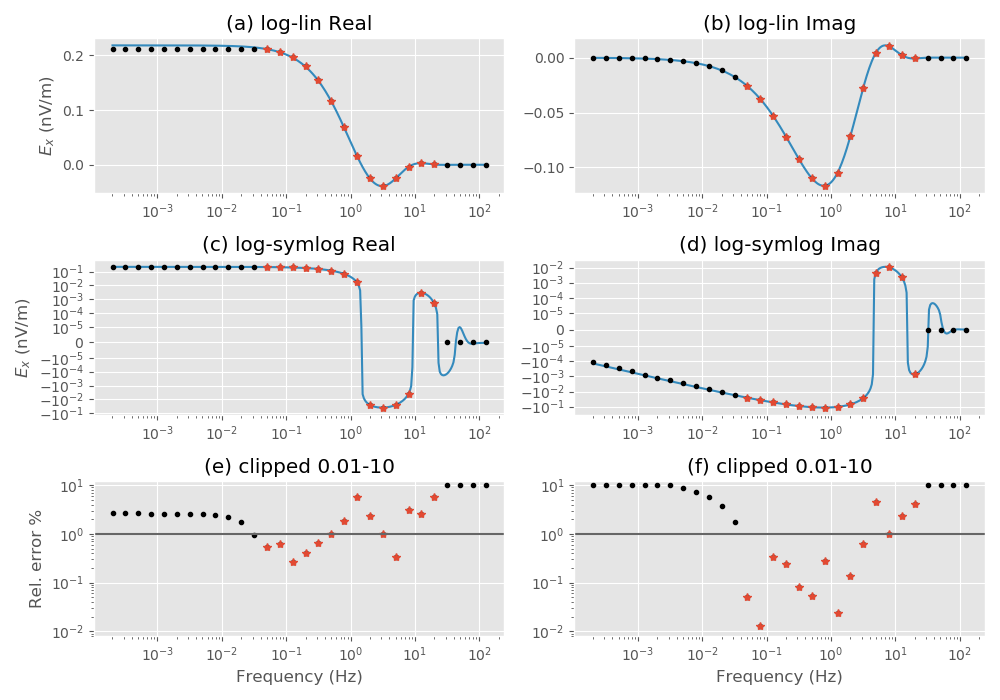

In [10]:
plt.figure(figsize=(10, 7))

# Real, log-lin
ax1 = plt.subplot(321)
plt.title('(a) log-lin Real')
plt.plot(freq_dense, 1e9*epm_dense.real, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.real, 'k.', label='interpolated')
plt.plot(Fourier.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')

# Real, log-symlog
ax3 = plt.subplot(323, sharex=ax1)
plt.title('(c) log-symlog Real')
plt.plot(freq_dense, 1e9*epm_dense.real, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.real, 'k.')
plt.plot(Fourier.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Real, error
ax5 = plt.subplot(325, sharex=ax3)
plt.title('(e) clipped 0.01-10')

# Calculate the error
err_int_r =  np.clip(100*abs((data_int.real-epm_req.real) /
                             epm_req.real), 0.01, 10)
err_cal_r = np.clip(100*abs((data.real-epm_calc.real) /
                            epm_calc.real), 0.01, 10)

plt.ylabel('Rel. error %')
plt.plot(Fourier.freq_req, err_int_r, 'k.')
plt.plot(Fourier.freq_calc, err_cal_r, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

# Imaginary, log-lin
ax2 = plt.subplot(322)
plt.title('(b) log-lin Imag')
plt.plot(freq_dense, 1e9*epm_dense.imag, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.imag, 'k.', label='interpolated')
plt.plot(Fourier.freq_calc, 1e9*data.imag, 'C0*')
plt.xscale('log')

# Imaginary, log-symlog
ax4 = plt.subplot(324, sharex=ax2)
plt.title('(d) log-symlog Imag')
plt.plot(freq_dense, 1e9*epm_dense.imag, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.imag, 'k.')
plt.plot(Fourier.freq_calc, 1e9*data.imag, 'C0*')

plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Imaginary, error
ax6 = plt.subplot(326, sharex=ax2)
plt.title('(f) clipped 0.01-10')

# Calculate error
err_int_i =  np.clip(100*abs((data_int.imag-epm_req.imag) /
                             epm_req.imag), 0.01, 10)
err_cal_i = np.clip(100*abs((data.imag-epm_calc.imag) /
                            epm_calc.imag), 0.01, 10)

plt.plot(Fourier.freq_req, err_int_i, 'k.')
plt.plot(Fourier.freq_calc, err_cal_i, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
#plt.savefig('./'+name+'_freq.pdf')
plt.show()

## Fourier Transform

Carry-out Fourier transform, calculate analytical result

In [11]:
# Calculate corresponding time-domain signal.
data_time = Fourier.freq2time(data, rec[0])

# Analytical result
epm_time_precise = empymod.dipole(src, rec, depth, res, time, signal=0, verb=1)
epm_time = empymod.dipole(src, rec, depth, res, time, signal=0, ft=Fourier.ft, ftarg=Fourier.ftarg, verb=1)

### Plot time-domain result

<IPython.core.display.Javascript object>


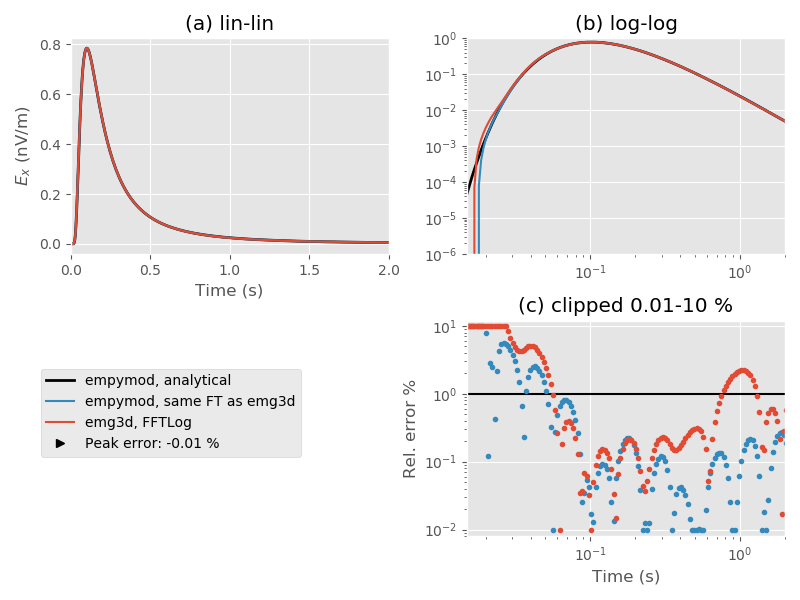

In [12]:
fig = plt.figure(figsize=(8, 6))

# lin-lin
plt.subplot(221)
plt.title('(a) lin-lin')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2)
plt.plot(time, epm_time*1e9, 'C1')
plt.plot(time, data_time*1e9, 'C0')
plt.ylabel('$E_x$ (nV/m)')
plt.xlim([0, 2])
plt.xlabel('Time (s)')

# log-log
ax2 = plt.subplot(222)
plt.title('(b) log-log')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2, label='empymod, analytical')
plt.plot(time, epm_time*1e9, 'C1', label='empymod, same FT as emg3d')
plt.plot(time, data_time*1e9, 'C0', label='emg3d, FFTLog')
plt.plot(-1, 1e9, 'k>', label=f"Peak error: {100*(max(data_time)-max(epm_time_precise))/max(epm_time_precise):.2f} %")
plt.xlim([1.5e-2, 2e0])
plt.ylim([1e-6, 1e0])
plt.xscale('log')
plt.yscale('log')

# Error
ax4 = plt.subplot(224, sharex=ax2)
plt.title('(c) clipped 0.01-10 %')

# Calculate error
err = np.clip(100*abs((data_time-epm_time_precise)/epm_time_precise), 0.01, 10)
err2 = np.clip(100*abs((epm_time-epm_time_precise)/epm_time_precise), 0.01, 10)

plt.loglog(time, err2, 'C1.')
plt.loglog(time, err, 'C0.')
plt.hlines(1, 0, 100)
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.ylim([0.008, 12])

plt.tight_layout()

# Plot peak error
ax2.legend(bbox_to_anchor=(-0.5, -0.5))

#plt.savefig('./'+name+'_time.pdf')
plt.show()

### Further explanations to the results in the above figure:

- The black line is the analytical fullspace solution in the time-domain.
- The blue result was obtained with empymod, using the same Fourier-transform parameters as used for `emg3d`, hence FFTLog with 5 pts per decade. However, in contrary to the red response, all frequencies are calculated, with a very high precision.
- The red result is the result obtain with `emg3d`. 

--------------------
## 2. Using DLF

We use the same frequencies and calculated data as in the FFTLog example, but apply the digital-linear-filter method for the transformation.

### Fourier Transform parameters for DLF

In [13]:
Fourier_dlf = emg3d.utils.Fourier(
    time=time,
    fmin=0.05,
    fmax=21,
    ft='sin',  # Fourier transform to use
    ftarg={'pts_per_dec': -1},
    freq_inp=Fourier.freq_req,  # Use same frequencies as in above example
)


# Dense frequencies for comparison reasons
freq_dense_dlf = np.logspace(np.log10(Fourier_dlf.freq_req.min()), np.log10(Fourier_dlf.freq_req.max()), 301)

# Get data
data_int_dlf = Fourier_dlf.interpolate(data)

# Calculate analytical result using empymod (epm)
epm_req_dlf = empymod.dipole(src, rec, depth, res, Fourier_dlf.freq_req, verb=1)
epm_calc_dlf = empymod.dipole(src, rec, depth, res, Fourier_dlf.freq_calc, verb=1)
epm_dense_dlf = empymod.dipole(src, rec, depth, res, freq_dense_dlf, verb=1)

   time        [s] :  0.01 - 10 : 201  [min-max; #]
   Fourier         :  DLF (Sine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   Req. freq  [Hz] :  1.4626E-08 - 1.80659E+07 : 251  [min-max; #]
   Calc. freq [Hz] :  0.0503292 - 20.0364 : 14  [min-max; #]


### Interpolate missing frequecies and calculate analytical result

In [14]:
data_int_dlf = Fourier_dlf.interpolate(data)

# Calculate analytical result using empymod (epm)
epm_req_dlf = empymod.dipole(src, rec, depth, res, Fourier_dlf.freq_req, verb=1)
epm_calc_dlf = empymod.dipole(src, rec, depth, res, Fourier_dlf.freq_calc, verb=1)
epm_dense_dlf = empymod.dipole(src, rec, depth, res, freq_dense_dlf, verb=1)

### Plot frequency-domain result

<IPython.core.display.Javascript object>


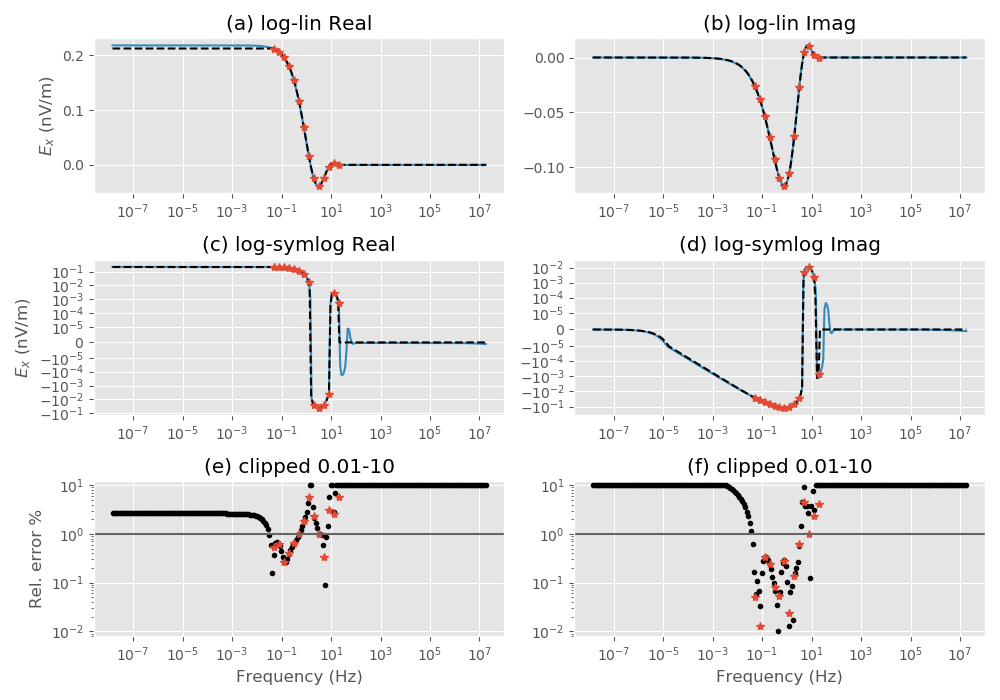

In [15]:
plt.figure(figsize=(10, 7))

# Real, log-lin
ax1 = plt.subplot(321)
plt.title('(a) log-lin Real')
plt.plot(freq_dense_dlf, 1e9*epm_dense_dlf.real, 'C1')
plt.plot(Fourier_dlf.freq_req, 1e9*data_int_dlf.real, 'k--', label='interpolated')
plt.plot(Fourier_dlf.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')

# Real, log-symlog
ax3 = plt.subplot(323, sharex=ax1)
plt.title('(c) log-symlog Real')
plt.plot(freq_dense_dlf, 1e9*epm_dense_dlf.real, 'C1')
plt.plot(Fourier_dlf.freq_req, 1e9*data_int_dlf.real, 'k--')
plt.plot(Fourier_dlf.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Real, error
ax5 = plt.subplot(325, sharex=ax3)
plt.title('(e) clipped 0.01-10')

# Calculate the error
err_int_r =  np.clip(100*abs((data_int_dlf.real-epm_req_dlf.real) /
                             epm_req_dlf.real), 0.01, 10)
err_cal_r = np.clip(100*abs((data.real-epm_calc_dlf.real) /
                            epm_calc_dlf.real), 0.01, 10)

plt.ylabel('Rel. error %')
plt.plot(Fourier_dlf.freq_req, err_int_r, 'k.')
plt.plot(Fourier_dlf.freq_calc, err_cal_r, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

# Imaginary, log-lin
ax2 = plt.subplot(322)
plt.title('(b) log-lin Imag')
plt.plot(freq_dense_dlf, 1e9*epm_dense_dlf.imag, 'C1')
plt.plot(Fourier_dlf.freq_req, 1e9*data_int_dlf.imag, 'k--', label='interpolated')
plt.plot(Fourier_dlf.freq_calc, 1e9*data.imag, 'C0*')
plt.xscale('log')

# Imaginary, log-symlog
ax4 = plt.subplot(324, sharex=ax2)
plt.title('(d) log-symlog Imag')
plt.plot(freq_dense_dlf, 1e9*epm_dense_dlf.imag, 'C1')
plt.plot(Fourier_dlf.freq_req, 1e9*data_int_dlf.imag, 'k--')
plt.plot(Fourier_dlf.freq_calc, 1e9*data.imag, 'C0*')

plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Imaginary, error
ax6 = plt.subplot(326, sharex=ax2)
plt.title('(f) clipped 0.01-10')

# Calculate error
err_int_i =  np.clip(100*abs((data_int_dlf.imag-epm_req_dlf.imag) /
                             epm_req_dlf.imag), 0.01, 10)
err_cal_i = np.clip(100*abs((data.imag-epm_calc_dlf.imag) /
                            epm_calc_dlf.imag), 0.01, 10)

plt.plot(Fourier_dlf.freq_req, err_int_i, 'k.')
plt.plot(Fourier_dlf.freq_calc, err_cal_i, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
#plt.savefig('./'+name+'_freq.pdf')
plt.show()

## Fourier Transform

Carry-out Fourier transform.

In [16]:
# Calculate corresponding time-domain signal.
data_time_dlf = Fourier_dlf.freq2time(data, rec[0])

### Plot time-domain result

<IPython.core.display.Javascript object>


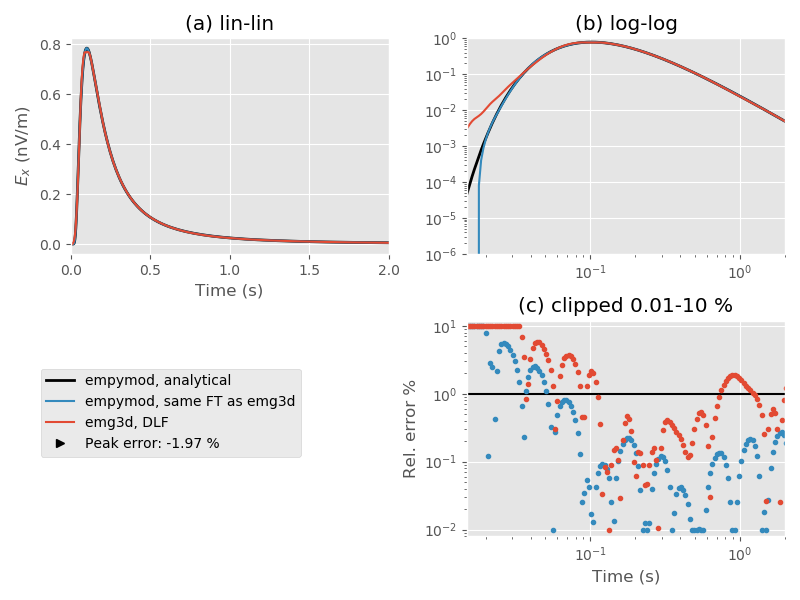

In [17]:
fig = plt.figure(figsize=(8, 6))

# lin-lin
plt.subplot(221)
plt.title('(a) lin-lin')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2)
plt.plot(time, epm_time*1e9, 'C1')
plt.plot(time, data_time_dlf*1e9, 'C0')
plt.ylabel('$E_x$ (nV/m)')
plt.xlim([0, 2])
plt.xlabel('Time (s)')

# log-log
ax2 = plt.subplot(222)
plt.title('(b) log-log')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2, label='empymod, analytical')
plt.plot(time, epm_time*1e9, 'C1', label='empymod, same FT as emg3d')
plt.plot(time, data_time_dlf*1e9, 'C0', label='emg3d, DLF')
plt.plot(-1, 1e9, 'k>', label=f"Peak error: {100*(max(data_time_dlf)-max(epm_time_precise))/max(epm_time_precise):.2f} %")
plt.xlim([1.5e-2, 2e0])
plt.ylim([1e-6, 1e0])
plt.xscale('log')
plt.yscale('log')

# Error
ax4 = plt.subplot(224, sharex=ax2)
plt.title('(c) clipped 0.01-10 %')

# Calculate error
err = np.clip(100*abs((data_time_dlf-epm_time_precise)/epm_time_precise), 0.01, 10)
err2 = np.clip(100*abs((epm_time-epm_time_precise)/epm_time_precise), 0.01, 10)

plt.loglog(time, err2, 'C1.')
plt.loglog(time, err, 'C0.')
plt.hlines(1, 0, 100)
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.ylim([0.008, 12])

plt.tight_layout()

# Plot peak error
ax2.legend(bbox_to_anchor=(-0.5, -0.5))

#plt.savefig('./'+name+'_time_dlf.pdf')
plt.show()

## 3. Results from Mulder et al., 2008, Geophysics

Total calculation time (CPU) is 13,632 s, which corresponds to 3 h 47 min 12 s.

![Figures 3-4 and Table 1](./data/figures/Mulder2008_Figs_3-4_Tab_1.png)

Figures 3 and 4 and Table 1, page F5 of Mulder et al., 2008, Geophysics.

In [18]:
emg3d.Report([empymod, discretize])

--------------------------------------------------------------------------------
  Date: Fri Nov 22 18:11:58 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.10.2 : empymod
            0.4.10 : discretize
            1.17.3 : numpy
             1.3.1 : scipy
            0.46.0 : numba
             0.9.1 : emg3d
             7.9.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------